# Time-frequency representations of power

The following  exercise covers how to calculate time-frequency representations of power using a time-window FFT approach. The consequences of tapering and using windows of different lengths will be discussed.

Please go through the exercises step-by-step and answer the questions.

Note the plots are made to commands using '#' . Remove the '#' to show plots.

First import the relevant Python modules: 

In [951]:
import matplotlib.pyplot as plt
import numpy as np
from random import gauss

## The test signal

The sampling frequency is set to 1024 Hz:

In [1068]:
Fs = 1024

Now define the test signal to be analyzed. The signal will have N = 1024 samples, i.e. it is 1 s long. Following a flat signal of 0.5 s (first 512 sample), there is a f0 = 10 Hz signal turning on lasting for 0.5 s. 

In [1069]:
f0 = 10

t = np.arange(0, 1,1/Fs)
t = np.arange(0, 1,1/Fs)
s = np.sin(2*np.pi*f0*t + 1.0)

N = 1024
s[0:int(N/2)-1] = -1

Add some Gaussian noise with a standard deviation of 0.2:

In [1070]:
s += np.random.normal(0, 0.2 , size = s.shape)

Add a sinusoidal signal to simulate the 50 Hz line noise: 

In [1071]:
s += 0.4*np.sin(2*np.pi*50*t) 

and plot the signal:

Text(0.5, 0, 'time (s)')

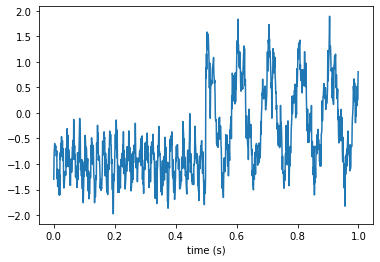

In [1072]:
plt.plot(t,s)
plt.xlabel('time (s)')

### The sliding time-window

The first step it to drag a time window over the data. This is done by selecting stretches of data around each sample points (e.g. 512 points). For instance, for sample point 300 we will select the stretch from 300-256 = 44 to 300+256-1 = 555. The boundaries create problems. In this case we will set the existing value to zero (zero-padding). E.g. for sample 1, the 255 values prior to the sample will be considered 0.

The following script with cut out the time windows; one time-window for each sample point (note that the script uses several ‘for loops’. In general this inefficient Matlab code; however, it is done for illustrative purposes).

Each time window will be Nwindow = 512 points long:


In [1073]:
Nwindow = 512

Now loop over the sample points and cut out the windows of interest.

In [1074]:
swindow = np.zeros((N,Nwindow))

for k in range(0,N-1):             # loop over all sample points
    nstart = k - int(Nwindow/2)    # define the start of time-window k
    nstop =  k + int(Nwindow/2)-1  # define the end of time-window k 
    n = 0
    for m in range(nstart,nstop):
        if m < 0 or m > N-1 :
            swindow[k][n] = 0      # Zero=pad at the boundary
        else:
            swindow[k][n]= s[m]    # Copy the data from s to time-window k
        n += 1

The windows are stored in the matrix swindow which in this case has 512 columns (the data samples the respective windows) and 1024 row (the total number of windows).


Plot the matrix swindow:

In [1090]:
# plt.imshow(swindow, origin='lower', aspect = 'auto')
# plt.xlabel('samples');
# plt.ylabel('window');
# plt.colorbar();

Try to identify the oscillations and zero-padding in the plot above. 

## Calculate the power spectra for each window

Now calculate the power spectrum for each time window. These is simply done by looping over the windows and then use the FFT algorithm to calculate the respective Fourier transforms. After, the power is calculated as the squared modulus of the Fourier transform (abs(Sfft).^2). The number of FFT points will be the same as the length of the windows:

In [1076]:
Nfft = Nwindow
P = np.zeros((N,Nwindow))
for k in range(0,N-1):
    Sfft = np.fft.fft(swindow[k,:])/(Nfft/2)
    P[k,:] = np.abs(Sfft) ** 2

print(P.shape)

(1024, 512)


This produces a matrix of power (P) with 1024 rows representing the windows and 512 columns representing the frequencies.

Calculate the frequency axis:

In [1077]:
f = (Fs/(Nfft))*np.arange(0, Nfft)

## Illustrating the power representations

Now plot the spectra from two representative time windows with respect to window 103 (t = 0.1 s) and sample 768 (t = 0.75 s). Limit the time x-axis from 0 to 60 Hz:


In [1091]:
#plt.plot(f,P[103,:],label='window 103')
#plt.plot(f,P[768,:],label='window 768')
#plt.xlim(0,60);plt.ylim(0,1)
#plt.xlabel('frequency (Hz)');plt.ylabel('Power')
#plt.legend()

### Question 1

Why is there a low frequency component for t = 0.1 s (window 103)?



The next step is to use a color representation to illustrate the time-frequency
representation of power. This is simply done by showing the ‘stacked power’ spectra:

In [1092]:
P2 = P[:,0:32]             # limit to 0-60 Hz
freqVec2 = freqVec[0:32]   # limit to 0-60 Hz

#plt.imshow(np.transpose(P2), vmin=0,vmax=0.4,origin='lower',aspect='auto',extent=[0,max(t)*1000,0,max(freqVec2)])
#plt.xlabel('time (ms)');plt.ylabel('frequency (Hz)'); plt.colorbar();

### Questions 2
Identify and describe the main features of the time-frequency representations in relation to the test signal

There are quite a lot of features in the power representations no related to the test signal per se. This is explained by spectral leakage being a consequence of the ‘boxcar’ shape of the windowed data. 

## Using Hanning tapers to reduce spectral leakage
The spectral representation can be improved by using a taper to reduce the spectral leakage. The Hanning taper we will use has the following shape:


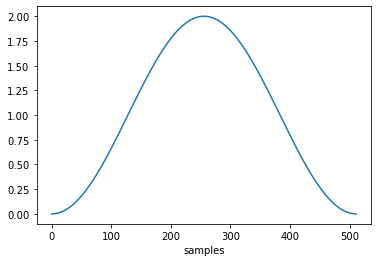

In [1080]:
taper = 2*np.hanning(Nfft)
plt.plot(taper)
plt.xlabel('samples');

This function is then multiplied to the data in each time window prior to calculating the Fourier transform:

In [1081]:
Nfft = Nwindow
P = np.zeros((N,Nwindow))
for k in range(0,N-1):
    Sfft = np.fft.fft(taper*swindow[k,:])/(Nfft/2)
    P[k,:] = np.abs(Sfft) ** 2

Now plot the time-frequency representations of power:

In [1093]:
f = (Fs/(Nfft))*np.arange(0, Nfft)
P2 = P[:,0:32]             # limit to 0-60 Hz
freqVec2 = freqVec[0:32]   # limit to 0-60 Hz

#plt.imshow(np.transpose(P2),vmin=0,vmax=0.4,origin='lower',aspect='auto',extent=[0,max(t)*1000,0,max(freqVec2)])
#plt.xlabel('time (ms)');plt.ylabel('frequency (Hz)'); plt.colorbar();

### Question 3:

- How did the taper improve the estimate?
- Identify the 10 Hz signal
    - How long does it take for i to turn on?
    - Why does the 10 Hz power dip around 1?
- Are there oscillations at ~1 Hz?
- Estimate the width of the 50 Hz line noise. Why did it expand after using a taper?

## Relationship to convolution and filtering

Recall that the Fourier transform at x Hz can be calculated by multiplying and then summing a cosine and a sine of x Hz to the signal of interest. This means that the power spectra we just calculated also could be derived by multiplying the cosine and sine to the data of each time window and calculating the respective sums (dot products). This can also be envisioned as multiplying a boxcar function to the data prior to calculating the Fourier transform. The boxcar is then moved one step forward. This is in effect the same a convolution in the discrete domain. Also recall that convolution in the time domain is the same as multiplication in the frequency domain. Thus we can qualitatively study the effect of the sliding (boxcar) time window by considering the power spectrum of the function cos(2 $\pi$ f t) + i sin(2 $\pi$ f t) where t are the time points of the window. This spectrum is informative for how the sliding time window affects the time-frequency estimate of power. We will do this for 9 Hz:

In [1094]:
tw = np.arange(0, Nfft)/Fs
sw = np.cos(2*np.pi*9*tw)
#plt.plot(tw,np.real(sw)) 

Now calculate the power spectrum and plot it (in dB):

In [1095]:
Swfft = np.fft.fft(sw,10240)/(10240/2);
Pw = np.abs(Swfft) ** 2;
fw = (Fs/10240)*np.arange(0,10240);

#plt.plot(fw,20*np.log10(Pw));
#plt.xlim(0,60);plt.ylim(-400,0)
#plt.xlabel('frequency(Hz)')

This figure illustrates the effect of using a sliding window (boxcar) to the data prior to
calculating the power estimate.

In the following step we will calculate the effect of using a Hanning taper. This is simply done by multiplying a Hanning function to the time window prior to calculating the power spectra:


In [1096]:
tw = np.arange(0, Nfft)/Fs
sw = np.cos(2*np.pi*9*tw)
taper = np.hanning(Nfft)
#plt.plot(tw,taper*np.real(sw)) 

Now plot the power spectrum after applying the Hanning taper:

In [1097]:
Swfft = np.fft.fft(taper*sw,10240)/(10240/2);
Pw = np.abs(Swfft) ** 2;
fw = (Fs/10240)*np.arange(0,10240);

#plt.plot(fw,20*np.log10(Pw));
#plt.xlim(0,60);plt.ylim(-400,0)
#plt.xlabel('frequency(Hz)')

### Question 4:

* How does the Hanning taper affect the attenuation?
* What does the Hanning taper do to the width of the spectral peak?


## Modifying the length of the time window
The most important way to modify the time-frequency representation of power is to change the length of the time window. First shorten the time to 256 points:

In [1087]:
Nwindow = 256

Now re-run the script in order to show the time-frequency representation of power.

### Question 5:
* What are the consequences for the temporal resolution?
* What are the consequences the frequency smearing? – consider both the 10 Hz and 50 Hz components
* What are the consequences for the temporal smearing?
* What does the spectral representation of the shorter taper look like? (show plot; derived as in Question 4)


Now lengthen the time window to

In [1088]:
Nwindow = 1024

and re-run the scripts.

### Question 6:
* Show new TFR plot
* What are the consequences for the temporal resolution?
* What are the consequences the frequency smearing? – consider both the 10 Hz and 50 Hz components
* What are the consequences for the temporal smearing?
* What does the spectral representation of the shorter taper look like? (show plot; derived as in Question 4)